In [39]:
from matplotlib import pyplot as plt
from time import sleep
import itertools
import TimeTagger
import numpy as np

In [9]:
tagger = TimeTagger.createTimeTagger()
input_channels = tagger.getChannelList(TimeTagger.ChannelEdge.Rising)
for ch in input_channels:
    tagger.setTriggerLevel(ch, 0.5)


In [40]:
# Set input delays to 0, otherwise the compensation result will be incorrect.
for ch in input_channels:
    tagger.setInputDelay(ch, 0)

# Create SynchronizedMeasurements to operate on the same time tags.
sm = TimeTagger.SynchronizedMeasurements(tagger)

#Create Correlation measurements
corr_list = list()
for ch in input_channels[1:]:
    corr_list.append(
        TimeTagger.Correlation(sm.getTagger(), input_channels[0], ch, binwidth=1, n_bins=5000)
    )
# Start measurements and accumulate data for 1 second
sm.startFor(int(1e12), clear=True)
sm.waitUntilFinished()
# Determine delays
delays = list()
for corr in corr_list:
    hist_t = corr.getIndex()
    hist_c = corr.getData()
    #Identify the delay as the center of the histogram through a weighted average
    dt = np.sum(hist_t * hist_c) / np.sum(hist_c)
    delays.append(int(dt))
print("Delays:", delays)
# Compensate the delays to align the signals
for ch, dt in zip(input_channels[1:], delays):
    tagger.setInputDelay(ch, dt)


Delays: [66, -279, 839]


In [22]:
order = 2
groups = list(itertools.combinations(input_channels, order))
coincidences_vchannels = TimeTagger.Coincidences(tagger, groups, coincidenceWindow=100)
print(groups)

[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


In [24]:
#Generate a list including input and virtual channels
channels = [*input_channels, *coincidences_vchannels.getChannels()]
counting = TimeTagger.Counter(tagger, channels, 1e10, 300)
measurementDuration = 10e12 # 10 s
counting.startFor(measurementDuration)
counting.waitUntilFinished()
index = counting.getIndex()
counts = counting.getData()

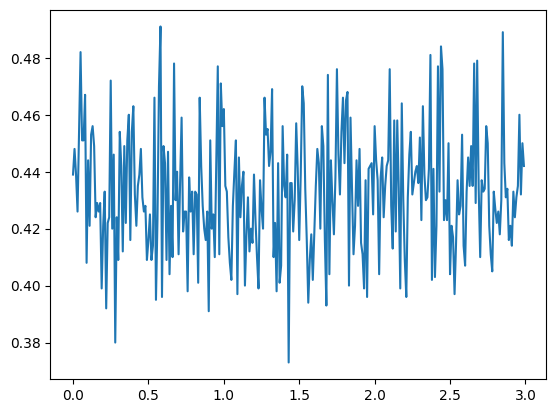

In [37]:
#plt.plot(counting.getIndex()/1e12, counts[0]*1e-3, label='channel 1')
plt.plot(counting.getIndex()/1e12, counts[0]*1e-3, label='channel 2')

Test signal on channel 1 enabled
Test signal on channel 2 enabled


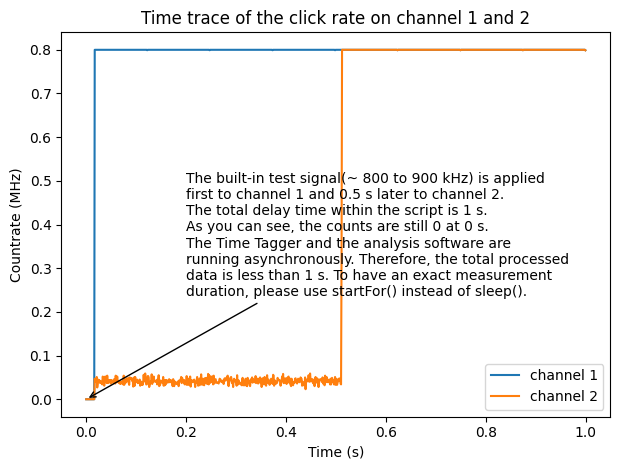

True

In [1]:
"""In this example, we learn how to start a simple measurement. We use the Counter class to measure a
count rate trace on channels 1 and 2 while switching on the built-in test signals.
For a demonstration of Counter.getDataObject(), see example 2-E."""



# Create a TimeTagger instance to control your hardware
tagger = TimeTagger.createTimeTagger()

# Create an instance of the Counter measurement class. It starts acquiring data immediately.
counter = TimeTagger.Counter(tagger=tagger, channels=[1, 2], binwidth=int(1e9), n_values=1000)

# Apply the built-in test signal (~0.8 to 0.9 MHz) to channel 1
tagger.setTestSignal(1, True)
print("Test signal on channel 1 enabled")
sleep(.5)

# Apply test signal to channel 2
tagger.setTestSignal(2, True)
print("Test signal on channel 2 enabled")

# After waiting two times for 0.5 s, the 1000 values should be filled
sleep(.5)

# Data is retrieved by calling the method "getData" on the measurement class.
data = counter.getData()

# Plot the result
plt.figure()
plt.plot(counter.getIndex()/1e12, data[0]*1e-3, label='channel 1')
plt.plot(counter.getIndex()/1e12, data[1]*1e-3, label='channel 2')
plt.xlabel('Time (s)')
plt.ylabel('Countrate (MHz)')
plt.legend()
plt.title('Time trace of the click rate on channel 1 and 2')
plt.annotate('''The built-in test signal(~ 800 to 900 kHz) is applied
first to channel 1 and 0.5 s later to channel 2.
The total delay time within the script is 1 s.
As you can see, the counts are still 0 at 0 s.
The Time Tagger and the analysis software are
running asynchronously. Therefore, the total processed
data is less than 1 s. To have an exact measurement
duration, please use startFor() instead of sleep().''',
             (0, 0),
             xytext=(100, 100),
             textcoords='offset pixels',
             arrowprops={'arrowstyle': '->'},
             va='bottom')
plt.tight_layout()
plt.show()

TimeTagger.freeTimeTagger(tagger)

